In [15]:
#Label the data
import pandas as pd
import numpy as np

y= pd.read_csv("/content/Labels.csv")
#Volatility
y['log_returns'] = y['Close'].rolling(window=2).apply(lambda x: np.log(x.iloc[1]/x.iloc[0]))
y['variance'] = y['log_returns'].rolling(window=10).var() # ==> Variance calculation 
y['variance'].fillna(0, inplace=True)
# Direction of the market
y['market_direction'] = y['Close'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] >= x.iloc[0] else 0)

 
y['market_direction'].fillna(0, inplace=True)
# Labelling
y_Volatility = y.reset_index()['variance'] *1000
y_Direction = y.reset_index()['market_direction']

In [11]:
def create_dataset(dataset,  time_step=3):
  #initial =[[0,0,0],[0,0,11734.32031],[0,11734.32031, 11782.34961]]
  dataX = []
  for i in range(len(dataset)-time_step+1):
    a = dataset[i:(i+time_step)]
    
    
    dataX.append(a )
    
  return numpy.array(dataX)

In [16]:
import numpy 
n=13
X_close = y.reset_index()['Close']
X_vol = y.reset_index()['Volume']
y = y_Direction

print(X_close.shape), print(y.shape)
X_close = pd.DataFrame(create_dataset(X_close,  n))
X_vol =pd.DataFrame(X_vol[n-1:]).reset_index()['Volume']
print(X_close.shape, X_vol.shape), print(y.shape)

X_2 = pd.concat([X_close, X_vol], axis=1)

y = y[n-1:]
print(X_2.shape), print(y.shape)

(1989,)
(1989,)
(1977, 13) (1977,)
(1989,)
(1977, 14)
(1977,)


(None, None)

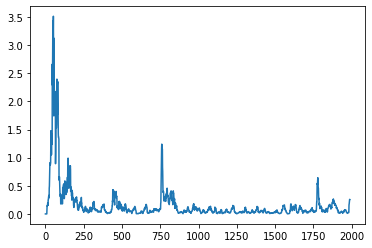

In [2]:
from matplotlib import pyplot as plt 
plt.plot(y_Volatility)

In [3]:
# Text data pre-processing
import nltk 
from nltk.corpus import stopwords
from nltk import stem
nltk.download('stopwords')

news_data =pd.read_csv("/content/Combined_News_DJIA.csv")
x= news_data.drop(['Label','Date'], axis=1)
x.columns = [str(c) for c in range(25)]

for i in x.columns:
    df = x[i].str.strip()     
    df = df.str.replace(' ', '_')   
    df= df.str.replace(r'b\'', '')
    df= df.str.replace(r'b\"', '')    
    df = df.str.replace(r"[^0-9a-zA-Z\_]+", "")
    df = df.str.replace('_+', ' ')  
    x[i]= df.str.lower()

x["combined_news"] = x.apply(lambda x: ''.join(str(x.values)), axis=1)
stopwords = nltk.corpus.stopwords.words('english')
ps = stem.PorterStemmer()

def clean_stem_stopWords(line: str ):
  return ' '.join(ps.stem(word) for word in line.split() if not word in stopwords)
x["combined_news"] = x["combined_news"].apply(lambda x: clean_stem_stopWords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1989


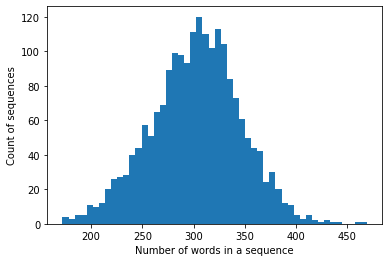

In [4]:
# Print the distribution of the sequence lengths
seq_len = [len(i.split()) for i in x["combined_news"]]
from matplotlib import pyplot as plt
print(len(seq_len))
plt.hist(pd.Series(seq_len),bins = 50)
plt.xlabel("Number of words in a sequence")
plt.ylabel("Count of sequences")

plt.show()

In [5]:
# simple tokenizer and padding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 350
MAX_NUM_WORDS = 10000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x["combined_news"])
data = tokenizer.texts_to_sequences(x["combined_news"])
data = pad_sequences(data, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(data.shape)

#Unique number of words
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

(1989, 350)
Found 42090 unique tokens


In [7]:
#Download pre-trained Word2Vec model from google
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

print('Found %s word vectors of word2vec' % len(word2vec.vocab))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Found 3000000 word vectors of word2vec


In [9]:
print('Preparing embedding matrix.')

# prepare Embedding matrix
nb_words = min(MAX_NUM_WORDS, len(word_index))+1
print("num_words",nb_words)
EMBEDDING_DIM =300

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    if word in word2vec.vocab:
      embedding_vector =word2vec.word_vec(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape) # it would have vectors for all indexes in our data

Preparing embedding matrix.
num_words 10001
(10001, 300)


In [10]:
# PCA feature reduction
from sklearn.decomposition import PCA
pca=PCA(n_components=250)
embedding_matrix_pca = pca.fit_transform(embedding_matrix)
print(embedding_matrix_pca.shape)

(10001, 250)


In [17]:
#### embedding layer
from keras.layers import Embedding

embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_pca],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [18]:
# choose right objective
#y= y_Volatility


from sklearn.preprocessing import StandardScaler

#scaler1 = StandardScaler()
scaler2 = StandardScaler()

#X_1 = scaler2.fit_transform(data)
X_2 = scaler2.fit_transform(X_2)
X_1=data



# Splitting the data:

num_validation_samples = 100
X_train1 = X_1[n-1:-num_validation_samples]
X_test1 = X_1[-num_validation_samples:]

X_train2 = X_2[:-num_validation_samples]
X_test2 = X_2[-num_validation_samples:]


y_train = y[:-num_validation_samples]
y_test = y[-num_validation_samples:]

In [19]:

print(X_train1.shape), print(y_train.shape)
print(X_train2.shape), print(y_train.shape)
print(X_test1.shape), print(y_test.shape)
print(X_test2.shape), print(y_test.shape)

(1877, 350)
(1877,)
(1877, 14)
(1877,)
(100, 350)
(100,)
(100, 14)
(100,)


(None, None)

In [20]:
X_train2 =X_train2.reshape(X_train2.shape[0],X_train2.shape[1] , 1)
X_test2 = X_test2.reshape(X_test2.shape[0],X_test2.shape[1] , 1)

In [ ]:
# Adding multiple features...working

from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Input, concatenate

EMBEDDING_DIM=250
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_pca],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#Model1 trained using the News data
nlp_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedded_sequences = embedding_layer(nlp_input)
model1 =LSTM(10, recurrent_dropout=0.2)(embedded_sequences) 


#Model2 trained from the stock data
meta_input = Input(shape=(14,1), name ='price')
model2 = LSTM(10, recurrent_dropout=0.2)(meta_input)

#Concatenate the two models
concat = concatenate([model1, model2])
classifier = Dense(10, activation='relu')(concat)
output = Dense(1,activation='sigmoid')(classifier)


model = Model(
    inputs=[ nlp_input,meta_input],
    outputs=[output]
)


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

history = model.fit([X_train1, X_train2],y_train,validation_data=([X_test1, X_test2],y_test),epochs=50,batch_size=10,verbose=1)


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 350, 250)     2500250     input_1[0][0]                    
__________________________________________________________________________________________________
price (InputLayer)              [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10)           10440       embedding_1[0][0]                
_______________________________________________________________________________________

In [21]:
# cross validation using K-fold
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Input, concatenate

def train_predict_LSTM_model(x_train, y_train ):
  EMBEDDING_DIM=250
  embedding_layer = Embedding(nb_words,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix_pca],
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=False)

  #Model1 trained using the News data
  nlp_input = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
  embedded_sequences = embedding_layer(nlp_input)
  model1 =LSTM(10, recurrent_dropout=0.2)(embedded_sequences) 


  #Model2 trained from the stock data
  meta_input = Input(shape=(14,1), name ='price')
  model2 = LSTM(10, recurrent_dropout=0.2)(meta_input)

  #Concatenate the two models
  concat = concatenate([model1, model2])
  classifier = Dense(10, activation='relu')(concat)
  output = Dense(1,activation='sigmoid')(classifier)


  model = Model(
      inputs=[ nlp_input,meta_input],
      outputs=[output]
  )


  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  print(model.summary())

  history = model.fit([X_train1, X_train2],y_train,validation_data=([X_test1, X_test2],y_test),epochs=50,batch_size=10,verbose=1)
  return model

In [23]:
from sklearn.model_selection import KFold
trains = []
tests = []
cv = KFold(n_splits=5, shuffle=False)
for train_index, test_index in cv.split(data):
    X_train, X_test, y_train, y_test = np.array(data)[train_index], np.array(data)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    #reshape for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test =X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    #Get the trained model
    model = train_predict_LSTM_model(X_train, y_train)
    #loss1, accuracy1 = model.evaluate(X_train, y_train)
    loss2, accuracy2 = model.evaluate(X_test, y_test)
    #print(model.metrics_names, accuracy1)
    #print(model.metrics_names, accuracy2)
    #trains.append(accuracy1) # add  squared=True for RMSE
    tests.append(accuracy2)

#print(" TRAIN mean score with std error:", np.mean(trains), np.var(trains))
print(" TEST mean score with std error:", np.mean(tests), np.var(tests))

IndexError: ignored

train mse 0.09132702228126838
val mse 0.037954080367324325
train score 0.3074388885862671
val score -9.772600537570524


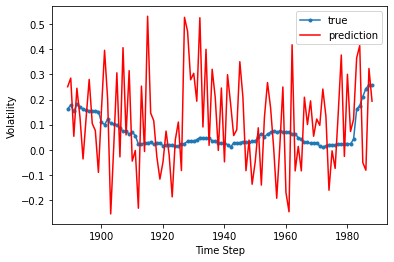

In [ ]:
# Simple Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

# select the model with K-fold validation to see the std error
model = LinearRegression()
model.fit(x_train,y_train)

y_pred= model.predict(x_val)
y_train_pred= model.predict(x_train)

print("train mse", mean_squared_error(y_train, y_train_pred))
print("val mse", mean_squared_error(y_val, y_pred))
print("train score", model.score(x_train, y_train))
print("val score", model.score(x_val, y_val))


plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Volatility')
plt.xlabel('Time Step')
#plt.ylim(0,5)
plt.savefig("LR.png")
plt.legend()
plt.show();


In [ ]:
# Linear Regression with K-fold to get std
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

# select the model with K-fold validation to see the std error
model = LinearRegression()
#model = KernelRidge()
#model = SVR(kernel='linear', max_iter=100)

trains = []
scores = []
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(data):
    X_train, X_test, y_train, y_test = np.array(data)[train_index], np.array(data)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_squared_error(model.predict(X_test), y_test )) # add  squared=True for RMSE
    trains.append(mean_squared_error(model.predict(X_train), y_train))

print(" TRAIN mean score with std error:", np.mean(trains), np.var(trains))
print(" TEST mean score with std error:", np.mean(scores), np.std(scores))


 TRAIN mean score with std error: 0.0852281788044891 0.0006249306395921664
 TEST mean score with std error: 0.1647475674217075 0.3347007967459076


In [ ]:
# Simple MLP
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout
input_shape = ( 150,)

# Create the model
model = Sequential()
model.add(Dense(50, kernel_regularizer='l2', input_shape=input_shape, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30,  input_shape=input_shape, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,  activation='relu'))
model.add(Dropout(0.2))

# mean_square_error and linear activation function for regression problem.
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])
#fit the model and statistics are stored in history for analysis
history = model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1, validation_split=0.2)

# Results with MLP
y_pred= model.predict(x_val)

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true - test data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction - test data")
plt.ylabel('Volatility')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();

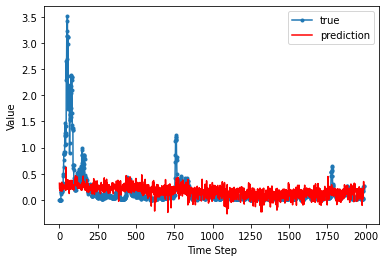

In [ ]:
# Compare Prediction results on train + validation data
plt.plot( y , marker='.', label="true")
plt.plot( np.append(y_train_pred,y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(0,5)
plt.legend()
plt.show();

In [ ]:
# MLP with K-fold cross validation
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout

def train_predict_MLP_model(x_train, y_train, x_val):


  input_shape = ( 150,)

  # Create the model
  model = Sequential()
  model.add(Dense(50, input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10,  activation='relu'))
  model.add(Dropout(0.2))

  # mean_square_error and linear activation function for regression problem.
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])
  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1, validation_split=0.2)
  return (model.predict(x_train), model.predict(x_val))


In [ ]:
trains = []
scores = []
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(X_pca):
    X_train, X_test, y_train, y_test = np.array(X_pca)[train_index], np.array(X_pca)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    
    (y_train_pred, y_pred)= train_predict_MLP_model(X_train, y_train, X_test)
    scores.append(mean_squared_error(y_pred, y_test )) # add  squared=True for RMSE
    trains.append(mean_squared_error(y_train_pred, y_train))

print(" TRAIN mean score with std error:", np.mean(trains), np.std(trains))
print(" TEST mean score with std error:", np.mean(scores), np.std(scores))

Epoch 1/50
144/144 [==============================] - 1s 4ms/step - loss: 0.1877 - mse: 0.1877 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 2/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 3/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 4/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.2287 - val_mse: 0.2287
Epoch 5/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.

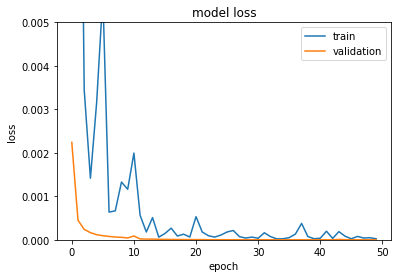

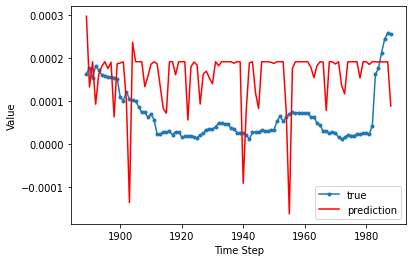

In [ ]:
# Results with MLP
y_pred= model.predict(x_val)

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,0.005)
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Price_MLP_val_2.png')
plt.show()

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();

In [ ]:
# Convert the data shape into 3-Dimensional for LSTM

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_val =x_val.reshape(x_val.shape[0],x_val.shape[1] , 1)

In [ ]:
# simple LSTM

from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Dense, Embedding, BatchNormalization, Dropout, LSTM

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_val =x_val.reshape(x_val.shape[0],x_val.shape[1] , 1)

# Create the model
model = Sequential()
EMBEDDING_DIM =250

model.add(Embedding(nb_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_pca),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model.add(LSTM(30, dropout=0.15, activation ='relu', input_shape=input_shape))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])

#fit the model and statistics are stored in history for analysis
history = model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

#y_pred= model.predict(x_val))


Epoch 1/20
152/152 [==============================] - 18s 121ms/step - loss: 0.1642 - mse: 0.1642 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 2/20
152/152 [==============================] - 19s 126ms/step - loss: 0.1610 - mse: 0.1610 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 3/20
152/152 [==============================] - 19s 126ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 4/20
152/152 [==============================] - 19s 127ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 5/20
152/152 [==============================] - 19s 126ms/step - loss: 0.1611 - mse: 0.1611 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 6/20
152/152 [==============================] - 19s 127ms/step - loss: 0.1609 - mse: 0.1609 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 7/20
152/152 [==============================] - 19s 126ms/step - loss: 0.1610 - mse: 0.1610 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 8/20
152/152 [==============================] - 1

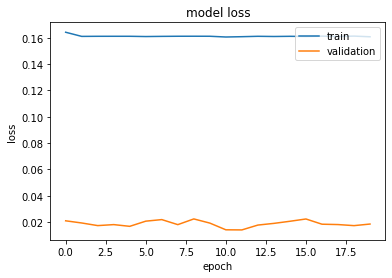

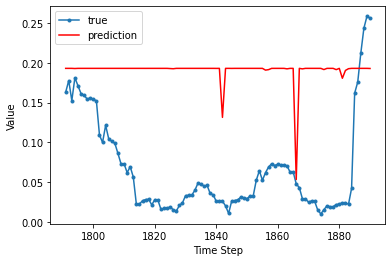

In [ ]:
# Results with LSTM
y_pred= model.predict(x_val)

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Price_MLP_val_2.png')
plt.show()

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();

In [ ]:
#LSTM with cross validation

from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout, LSTM

def train_predict_LSTM_model(x_train, y_train, x_val ):
  x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
  x_val =x_val.reshape(x_val.shape[0],x_val.shape[1] , 1)
  input_shape = ( 250,1)



  # Create the model
  model = Sequential()
  model.add(Embedding(nb_words,
                          EMBEDDING_DIM,
                          embeddings_initializer=Constant(embedding_matrix_pca),
                          input_length=MAX_SEQUENCE_LENGTH,
                          trainable=False))
  
  model.add(LSTM(30, dropout=0.15, activation ='relu', input_shape=input_shape))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])

  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

  #Results with LSTM
  return (model.predict(x_train), model.predict(x_val))

trains = []
scores = []
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(data):
    X_train, X_test, y_train, y_test = np.array(data)[train_index], np.array(data)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    
    (y_train_pred, y_pred)= train_predict_LSTM_model(X_train, y_train, X_test)
    scores.append(mean_squared_error(y_pred, y_test )) # add  squared=True for RMSE
    #trains.append(mean_squared_error(y_train_pred, y_train))

#print(" TRAIN mean score with std error:", np.mean(trains), np.std(trains))

print(" TEST mean score with std error:", np.mean(scores), np.std(scores))

Epoch 1/20
144/144 [==============================] - 17s 121ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 2/20
144/144 [==============================] - 17s 120ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 3/20
144/144 [==============================] - 17s 119ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 4/20
144/144 [==============================] - 17s 120ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 5/20
144/144 [==============================] - 17s 119ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 6/20
144/144 [==============================] - 17s 119ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 7/20
144/144 [==============================] - 17s 119ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 8/20
144/144 [==============================] - 1

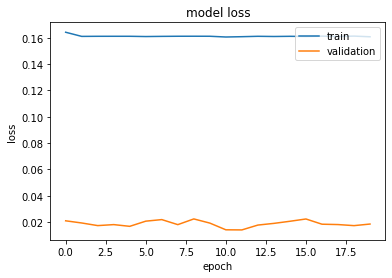

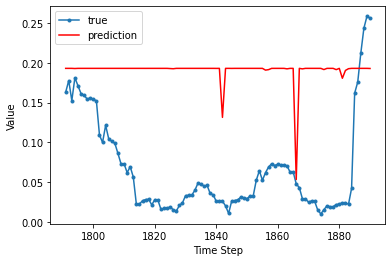

In [ ]:
# Results with LSTM
y_pred= model.predict(x_val)

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Price_MLP_val_2.png')
plt.show()

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();